In [19]:
import torch
import torch.nn as nn
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler,StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau


plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["figure.figsize"] = (12, 6)

In [20]:
df = pd.read_csv('../data/50area_dummy_processed.csv')

In [ ]:
df

In [3]:
df['requested_kwh']

0         12.62
1         17.81
2         41.30
3         21.08
4          9.30
          ...  
243607    42.55
243608    31.38
243609    40.31
243610    28.97
243611    19.69
Name: requested_kwh, Length: 243612, dtype: float64

In [4]:
# numerical_columns=[
#     "last_charge_end_time_ts",
#     "connection_start_time_ts",
#     "charging_start_time_ts",
#     "charging_end_time_ts",
#     "connection_end_time_ts",
#     "expected_departure_time_ts",
#     "idle_time_ts",
#     "expected_usage_duration_ts",
#     "expected_time_diff_ts",
#     "actual_usage_duration_ts",
#     "actual_charging_duration_ts",
#     "start_delay_duration_ts",
#     "post_charge_departure_delay_ts",
#     "usage_departure_time_diff_ts",
#     "duration_per_kwh_ts",
#     "delivered_kwh",
#     "kwh_request_diff",
#     "kwh_per_usage_time",
# ]


In [5]:
numerical_columns=[
    "delivered_kwh",
    "kwh_request_diff",
    "kwh_per_usage_time",
]


In [6]:
time_series_columns = [
    'last_charge_end_time_ts',
    'connection_start_time_ts',
    'charging_start_time_ts',
    'charging_end_time_ts',
    'connection_end_time_ts',
    'expected_departure_time_ts',
    'idle_time_ts',
    'expected_usage_duration_ts',
    'expected_time_diff_ts',
    'actual_usage_duration_ts',
    'actual_charging_duration_ts',
    'start_delay_duration_ts',
    'post_charge_departure_delay_ts',
    'usage_departure_time_diff_ts',
    'duration_per_kwh_ts'
]


In [7]:
categorical_columns = [
            'evse_type', 'supports_discharge', 'scheduled_charge','weekday'
            ,'usage_departure_range','post_charge_departure_range','cluster'
        ]

In [8]:
class EVChargeOneDataset(Dataset):
    def __init__(self, df, seq_length=10, target_col='requested_kwh',
                 group_cols=['station_location'],
                 isTrain=True,
                 input_scaler=None,
                 target_scaler=None):

        self.seq_length = seq_length
        self.target_col = target_col
        self.numerical_columns = numerical_columns.copy()
        self.input_scaler = input_scaler
        self.target_scaler = target_scaler
        sequences = []
        joblib.dump(self.numerical_columns, "../model/numeric_cols.pkl")

        df = df.copy()
        df.replace({'evse_type': {'': np.nan}}, inplace=True)
        df[self.numerical_columns] = df[self.numerical_columns].fillna(0).astype(np.float32)
        df[self.target_col] = df[self.target_col].fillna(0).astype(np.float32)

        df = pd.get_dummies(df, columns= ['evse_type','weekday'], drop_first=False)

        # numerical_columns를 여기서 새로 만듭니다
        one_hot_columns = [col for col in df.columns if col.startswith('evse_type_') or col.startswith('weekday_')]
        df[one_hot_columns] = df[one_hot_columns].fillna(0).astype(np.float32)
        input_columns = numerical_columns + one_hot_columns
        #input_columns.remove(self.target_col)
        self.input_columns = input_columns

        # ✅ 입력 피처 정규화
        if isTrain:
            df[self.numerical_columns] = self.input_scaler.fit_transform(df[self.numerical_columns])
            df[[self.target_col]] = self.target_scaler.fit_transform(df[[self.target_col]])
            joblib.dump(self.input_scaler, "../model/input_scaler.pkl")
            joblib.dump(self.target_scaler, "../model/target_scaler.pkl")
            joblib.dump(self.input_columns, "../model/expected_features.pkl")
        else:
            df[self.numerical_columns] = self.input_scaler.transform(df[self.numerical_columns])
            df[[self.target_col]] = self.target_scaler.transform(df[[self.target_col]])

        grouped = df.groupby(group_cols)

        for _, group_df in grouped:
            group_df = group_df.sort_values('last_charge_end_time_ts')
            if len(group_df) <= seq_length:
                continue

            x = group_df[self.input_columns].values.astype(np.float32)
            y = group_df[self.target_col].values.astype(np.float32)

            for i in range(len(x) - seq_length):
                x_seq = x[i:i + seq_length]
                y_target = y[i + seq_length]
                sequences.append((x_seq, y_target))
        # group_cols 기준으로 그룹 수 확인
        df['group_id'] = df[group_cols].astype(str).agg('_'.join, axis=1)

        # 전체 그룹별 row 수 (시퀀스 생성 전 기준)
        group_counts = df['group_id'].value_counts()

        # ✅ 시퀀스로 실제 사용 가능한 그룹만 보기 (조건: len > seq_length)
        min_seq_len = 10 # 또는 Dataset에서 사용한 self.seq_length
        usable_group_counts = group_counts[group_counts > min_seq_len]

        # 결과 출력
        print(f"⚡ 전체 그룹 수: {group_counts.shape[0]}")
        print(f"✅ 시퀀스로 사용 가능한 그룹 수: {usable_group_counts.shape[0]}")
        print(f"📊 그룹별 row 수 (상위 10개):\n{group_counts.head(10)}")


        self.x = torch.tensor([seq[0] for seq in sequences], dtype=torch.float32)
        self.y = torch.tensor([seq[1] for seq in sequences], dtype=torch.float32)
        print(input_columns)
        print("🟡 NaN in input:", np.isnan(self.x.numpy()).sum())
        print("🟡 NaN in target:", np.isnan(self.y.numpy()).sum())

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


In [9]:
class EVChargeDataset(Dataset):
    def __init__(self, df, seq_length=10, target_col='requested_kwh',
                 numerical_columns=numerical_columns, group_cols=['station_location', 'evse_name'],isTrain=True,scaler = None):

        self.seq_length = seq_length
        self.target_col = target_col
        self.numerical_columns = numerical_columns
        self.scaler = scaler
        sequences = []

        df = df.copy()
        df.columns = df.columns.str.strip()
        # "False", "True" 등 문자열 → 불리언으로 변환
        df.replace({'False': False, 'True': True}, inplace=True)
        # 빈 문자열을 통일된 NaN으로 변환
        df.replace('', np.nan, inplace=True)
        # 마지막으로 NaN 전부 0으로 채움
        df[numerical_columns] = df[numerical_columns].fillna(0).astype(np.float32)


        if(isTrain):
            df[self.numerical_columns] = self.scaler.fit_transform(df[self.numerical_columns])
            # 스케일러 객체를 파일로 저장
            joblib.dump(self.scaler, "../model/robust_scaler.pkl")
            joblib.dump(self.numerical_columns, "../model/numeric_cols.pkl")
        else:
            df[self.numerical_columns] = self.scaler.transform(df[self.numerical_columns])
            
        # # 범주형 변수 → 원핫 인코딩
        # df = pd.get_dummies(df, columns=categorical_columns, drop_first=False)

        # 최종 입력에 사용할 컬럼 정의 (원핫 포함)
        all_columns = df.select_dtypes(include=[np.number]).columns.tolist()
        all_columns.remove(target_col)  # 타겟은 제외
         # ✅ 최종 입력 피처 저장
        print(all_columns)
        joblib.dump(all_columns, "../model/expected_features.pkl")
        self.input_columns = all_columns  # 시계열 시 사용


        # 그룹별 시계열 생성
        grouped = df.groupby(group_cols)

        for _, group_df in grouped:
            group_df = group_df.sort_values('last_charge_end_time_ts')
            if len(group_df) <= seq_length:
                continue

            x = group_df[self.input_columns].values.astype(np.float32)
            y = group_df[self.target_col].values.astype(np.float32)


            for i in range(len(x) - seq_length):
                x_seq = x[i: i + seq_length]
                y_target = y[i + seq_length]
                if np.isnan(x_seq).any() or np.isnan(y_target):   # ✅ NaN 있으면 건너뜀
                    continue
                sequences.append((x_seq, y_target))
                
        self.x = torch.tensor([seq[0] for seq in sequences], dtype=torch.float32)
        self.y = torch.tensor([seq[1] for seq in sequences], dtype=torch.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


In [10]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [11]:
seq_length = 10
# seq_length = 30
batch_size = 256
scaler = RobustScaler()

input_scaler = StandardScaler()
target_scaler = StandardScaler()


# 생성
train_dataset = EVChargeOneDataset(df_train, isTrain=True, input_scaler=input_scaler, target_scaler=target_scaler)
test_dataset = EVChargeOneDataset(df_test, isTrain=False, input_scaler=input_scaler, target_scaler=target_scaler)

# train_dataset = EVChargeDataset(df=df_train,seq_length=seq_length,
#                                 numerical_columns=numerical_columns,group_cols=['station_location', 'evse_name'],scaler=scaler)
# test_dataset = EVChargeDataset(df=df_test, seq_length=seq_length,
#                                numerical_columns=numerical_columns,group_cols=['station_location', 'evse_name'],isTrain=False,scaler=scaler)

# train_dataset = EVChargeTimeDataset(df=df_train,seq_length=seq_length,
#                                     time_series_columns=time_series_columns,group_cols=['station_location', 'evse_name'],
#                                     target_col='requested_kwh')
# test_dataset = EVChargeTimeDataset(df=df_test, seq_length=seq_length,
#                                    time_series_columns=time_series_columns,group_cols=['station_location', 'evse_name'],
#                                    target_col='requested_kwh')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

⚡ 전체 그룹 수: 193
✅ 시퀀스로 사용 가능한 그룹 수: 193
📊 그룹별 row 수 (상위 10개):
group_id
PW014244    10767
PW013242     6726
PI717134     6658
HM001308     6447
NT100717     6216
PW013441     5677
HM001096     5571
PW013311     5279
PIH01369     3007
PI717223     2849
Name: count, dtype: int64


C:\Users\user\AppData\Local\Temp\ipykernel_22544\4017792193.py:71: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  self.x = torch.tensor([seq[0] for seq in sequences], dtype=torch.float32)


['delivered_kwh', 'kwh_request_diff', 'kwh_per_usage_time', 'evse_type_FC', 'evse_type_SC', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6']
🟡 NaN in input: 0
🟡 NaN in target: 0
⚡ 전체 그룹 수: 193
✅ 시퀀스로 사용 가능한 그룹 수: 193
📊 그룹별 row 수 (상위 10개):
group_id
PW014244    2702
PI717134    1678
PW013242    1649
HM001308    1627
NT100717    1583
PW013441    1389
PW013311    1360
HM001096    1351
PIH01369     793
PI717223     713
Name: count, dtype: int64
['delivered_kwh', 'kwh_request_diff', 'kwh_per_usage_time', 'evse_type_FC', 'evse_type_SC', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6']
🟡 NaN in input: 0
🟡 NaN in target: 0


In [12]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        return self.fc(h_n.squeeze(0))

In [13]:
input_size = 12
hidden_size = 128
output_size = 1
num_epochs = 10000
learning_rate = 0.0001

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [15]:
lstm_model = LSTMModel(input_size, hidden_size, output_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate)

scheduler = ReduceLROnPlateau(optimizer=optimizer, mode="min",factor=0.5,patience=10)
# 검증 손실이 줄어들지 않을 때, 학습률을 줄임
# 0.5
# 10줄였는데 안줄면 멈춘다.

# 종기 종료 파라미터
patience_counter_lstm = 0
best_val_loss_lstm = float("inf")
best_model_state_dict_lstm = None
patience = 10
epoch_train_losses = []
epoch_val_losses = []
for epoch in range(num_epochs):
    lstm_model.train()
    epoch_train_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        optimizer.zero_grad()
        outputs = lstm_model(batch_X)
        loss = criterion(outputs, batch_y.unsqueeze(-1))
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()    
    epoch_train_loss /= len(train_loader)

    if (epoch + 1) % 10 == 0:
        print(f"LSTM Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item(): 4f}")

    lstm_model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            outputs = lstm_model(batch_X)
            loss = criterion(outputs, batch_y.unsqueeze(-1))
            epoch_val_loss += loss.item()
    epoch_val_loss /= len(test_loader)          

    scheduler.step(epoch_val_loss)
    epoch_train_losses.append(epoch_train_loss)
    epoch_val_losses.append(epoch_val_loss)

    if (epoch+1) % 10 == 0:
        print(f'LSTM Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}')

    if epoch_val_loss < best_val_loss_lstm:
        best_val_loss_lstm = epoch_val_loss
        patience_counter_lstm = 0
        best_model_state_dict_lstm = copy.deepcopy(lstm_model.state_dict())
    else:
        patience_counter_lstm += 1
        if patience_counter_lstm >= patience:
            print(
                f"LSTM 조기종료 [{epoch+1}/{num_epochs}], Val Loss: {epoch_val_loss:.4f}"
            )
            break

if best_model_state_dict_lstm:
    lstm_model.load_state_dict(best_model_state_dict_lstm)
    torch.save(best_model_state_dict_lstm, "../model/lstm_model_best.pth")
else:
    print(f"조기종료 하지 못 했음")

# 예측값 모으기
lstm_model.eval()
lstm_test_predictions = []
with torch.no_grad():
    for batch_X, _ in test_loader:
        batch_X = batch_X.to(device)
        outputs = lstm_model(batch_X)
        lstm_test_predictions.append(outputs.cpu().numpy())

lstm_test_predictions = np.concatenate(lstm_test_predictions)  # shape (N, 1)

# ✅ 예측값 역변환 (타깃 scaler 이용!)
lstm_test_predictions_rescaled = target_scaler.inverse_transform(lstm_test_predictions)

# 실제값 역변환
y_test_tensor = test_dataset.y.unsqueeze(1).cpu().numpy()
y_test_rescaled = target_scaler.inverse_transform(y_test_tensor)


LSTM Epoch [10/10000], Loss:  1.050785
LSTM Epoch [10/10000], Train Loss: 1.0007
LSTM Epoch [20/10000], Loss:  0.943575
LSTM Epoch [20/10000], Train Loss: 1.0005
LSTM 조기종료 [21/10000], Val Loss: 0.9995


In [16]:
# 비교 출력
for i in range(10):
    print(f"[{i}] 실제: {y_test_rescaled[i][0]:.2f}  예측: {lstm_test_predictions_rescaled[i][0]:.2f}")


[0] 실제: 31.97  예측: 21.28
[1] 실제: 37.29  예측: 21.39
[2] 실제: 21.11  예측: 21.43
[3] 실제: 26.80  예측: 21.12
[4] 실제: 34.60  예측: 21.22
[5] 실제: 22.36  예측: 21.24
[6] 실제: 39.42  예측: 21.19
[7] 실제: 16.23  예측: 21.19
[8] 실제: 13.46  예측: 21.01
[9] 실제: -0.00  예측: 20.98


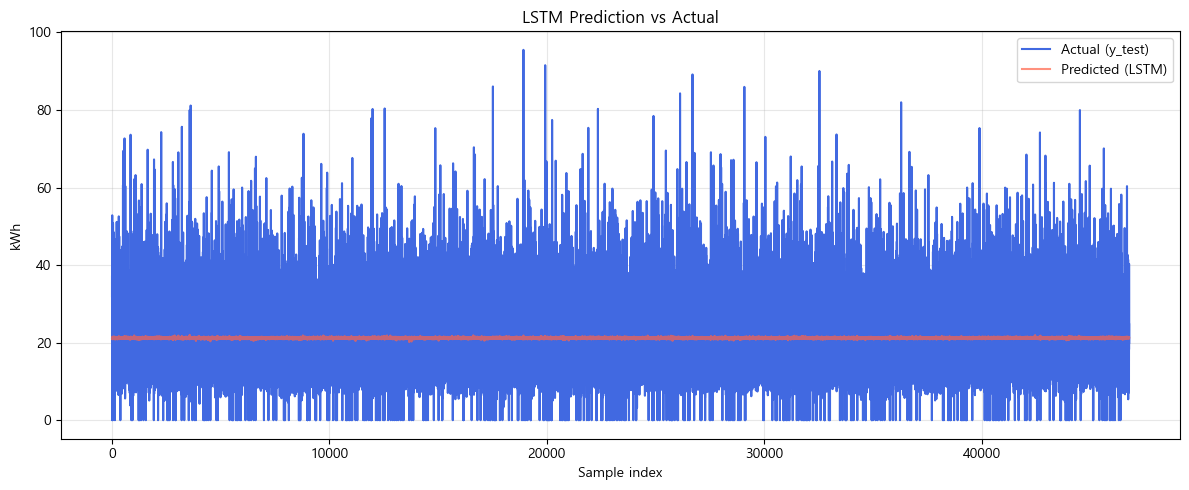

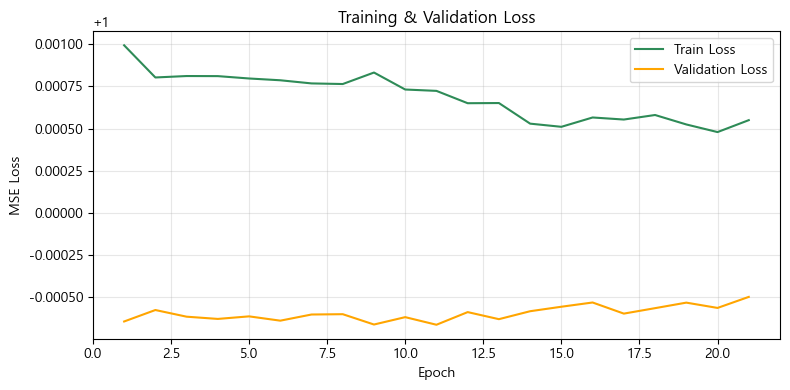

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# ──────────────────────────────────────────────
# 1. 예측값 vs 실제값 라인플롯
# ──────────────────────────────────────────────
plt.figure(figsize=(12, 5))
plt.plot(y_test_rescaled, label='Actual (y_test)', color='royalblue')
plt.plot(lstm_test_predictions_rescaled, label='Predicted (LSTM)', color='tomato', alpha=0.7)
plt.title('LSTM Prediction vs Actual')
plt.xlabel('Sample index')
plt.ylabel('kWh')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ──────────────────────────────────────────────
# 2. 학습/검증 손실 곡선(옵션)
#   - epoch_train_losses, epoch_val_losses 리스트가
#     에포크마다 손실을 저장하고 있다고 가정합니다.
# ──────────────────────────────────────────────
# 예: 학습 루프 안에서
# epoch_train_losses.append(epoch_train_loss)
# epoch_val_losses.append(epoch_val_loss)

try:
    # 두 리스트가 존재할 때만 그리도록 예외 처리
    plt.figure(figsize=(8, 4))
    epochs = np.arange(1, len(epoch_train_losses) + 1)
    plt.plot(epochs, epoch_train_losses, label='Train Loss', color='seagreen')
    plt.plot(epochs, epoch_val_losses, label='Validation Loss', color='orange')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
except NameError:
    print("epoch_train_losses / epoch_val_losses 리스트가 없습니다. "
          "학습 루프에서 손실을 저장해 주세요.")
